# Bulk Ri analysis

Consolidating code for bulk Ri paper 

In [1]:
import dcpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr

import facetgrid
import pump

mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.dpi"] = 180

xr.set_options(keep_attrs=True)

In [2]:
import dask
import distributed
import ncar_jobqueue

cluster = ncar_jobqueue.NCARCluster(project="ncgd0011")
cluster.scale(4)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://10.12.205.200:36906 Dashboard: https://jupyterhub.ucar.edu/dav/user/dcherian/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Read datasets

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


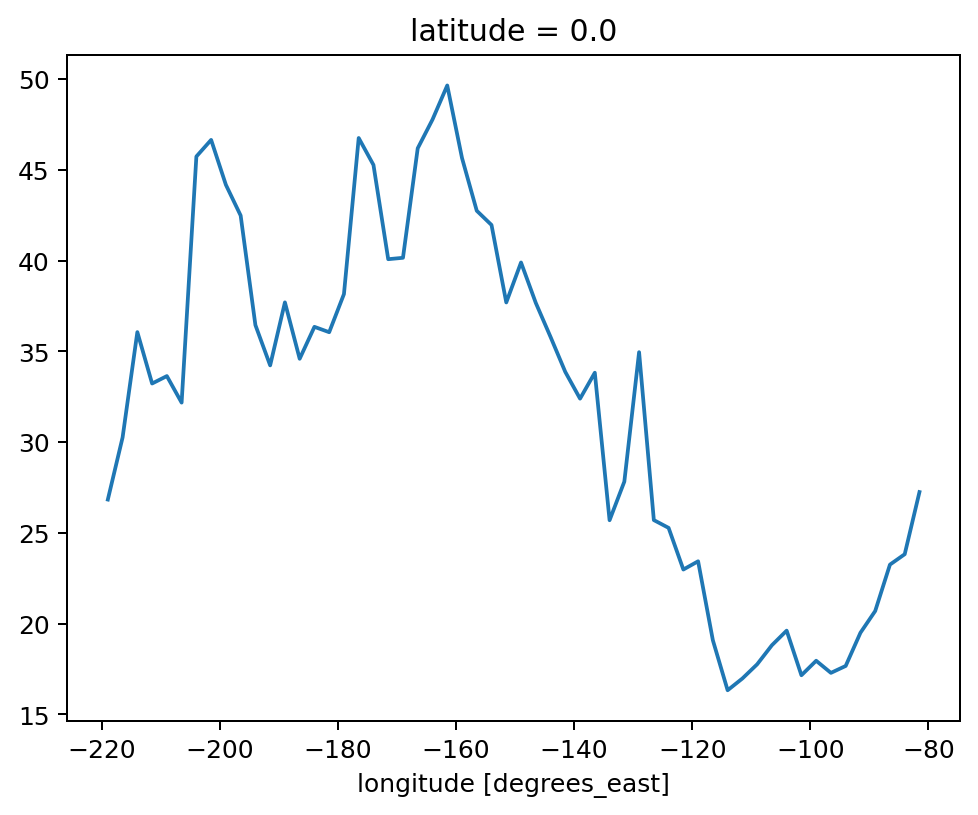

In [2]:
mimoc = dcpy.oceans.read_mimoc("/glade/u/home/dcherian/datasets/mimoc/")
mimoc["longitude"] = mimoc.longitude - 360
mimocmld = (
    mimoc.DEPTH_MIXED_LAYER.coarsen(longitude=5, boundary="pad")
    .mean()
    .sel(longitude=slice(-220, -80))
    .sel(latitude=0, method="nearest")
    .max("time")
)

mimocmld.plot()

In [8]:
johnson = pump.obs.read_johnson().sel(latitude=0)
johnson["eucmax"] = pump.get_euc_max(johnson.u)
johnson = pump.calc.estimate_euc_depth_terms(johnson)
johnson.attrs["name"] = "Johnson"
johnson["mld"] = mimocmld.interp(longitude=johnson.longitude.values).load()
johnson.load()

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:    (depth: 50, lon_edges: 11, longitude: 10)
Coordinates:
  * longitude  (longitude) float64 -217.0 -204.0 -195.0 ... -125.0 -110.0 -95.0
  * lon_edges  (lon_edges) float64 136.5 149.5 160.5 172.5 ... 242.5 257.5 272.5
    latitude   float64 0.0
  * depth      (depth) float64 -5.0 -15.0 -25.0 -35.0 ... -475.0 -485.0 -495.0
Data variables:
    temp       (depth, longitude) float32 29.32 29.32 28.99 ... 8.132 8.024
    salt       (depth, longitude) float32 34.19 34.45 34.77 ... 34.63 34.63
    dens       (depth, longitude) float32 1.021e+03 1.022e+03 ... 1.027e+03
    u          (depth, longitude) float32 0.08696 0.1127 0.01524 ... nan nan nan
    TSPTS      (depth, longitude) float32 20.0 34.0 28.0 46.0 ... 47.0 38.0 24.0
    UPTS       (depth, longitude) float32 20.0 34.0 27.0 45.0 ... nan 2.362 nan
    eucmax     (longitude) float64 -215.0 -185.0 -185.0 ... -85.0 -75.0 -65.0
    h          (longitude) float64 -185.0 -140.0 -115.0 ... -60.0 -55.0 -45.0
    us         (longitude) float32 0.0462 0.01897 0.1007 ... 0.06764 -0.01617
    ueuc       (longitude) float32 0.424 0.4945 0.4252 ... 1.11 0.9162 0.7123
    du         (longitude) float32 -0.3777 -0.4755 -0.3244 ... -0.8485 -0.7285
    dens_euc   (longitude) float32 1.026e+03 1.025e+03 ... 1.026e+03 1.026e+03
    b          (depth, longitude) float32 -9.766 -9.774 -9.776 ... -9.822 -9.822
    bs         (longitude) float32 -9.767 -9.778 -9.777 ... -9.794 -9.791 -9.79
    beuc       (longitude) float32 -9.81 -9.81 -9.81 -9.81 ... -9.81 -9.81 -9.81
    db         (longitude) float32 0.04333 0.03237 0.03319 ... 0.01902 0.01996
    Rib        (longitude) float64 56.18 20.04 36.27 12.32 ... 1.185 1.453 1.692
    mld        (longitude) float64 29.57 45.73 38.86 37.31 ... 25.44 17.44 17.51
Attributes:
    history:  FERRET V5.41    1-Oct-02
    name:     Johnson

In [4]:
tao = pump.obs.read_tao_zarr("ancillary")
tao.depth.attrs["units"] = "m"
tao

<xarray.Dataset>
Dimensions:    (depth: 101, longitude: 5, time: 292267)
Coordinates:
    deepest    (time, longitude) float64 dask.array<chunksize=(10000, 1), meta=np.ndarray>
  * depth      (depth) float64 -500.0 -495.0 -490.0 -485.0 ... -10.0 -5.0 0.0
    eucmax     (time, longitude) float64 dask.array<chunksize=(10000, 1), meta=np.ndarray>
    latitude   float32 ...
  * longitude  (longitude) float64 -204.0 -195.0 -170.0 -140.0 -110.0
    mld        (time, longitude) float64 dask.array<chunksize=(10000, 1), meta=np.ndarray>
  * time       (time) datetime64[ns] 1985-10-01T06:00:00 ... 2019-02-03
    zeuc       (depth, time, longitude) float64 dask.array<chunksize=(101, 10000, 1), meta=np.ndarray>
Data variables:
    Rig        (time, longitude, depth) float64 dask.array<chunksize=(10000, 1, 101), meta=np.ndarray>
    T          (time, longitude, depth) float64 dask.array<chunksize=(10000, 1, 101), meta=np.ndarray>
    dens       (time, longitude, depth) float64 dask.array<chunksize=(10000, 1, 101), meta=np.ndarray>
    u          (time, depth, longitude) float32 dask.array<chunksize=(10000, 101, 1), meta=np.ndarray>
    v          (time, depth, longitude) float32 dask.array<chunksize=(10000, 101, 1), meta=np.ndarray>

In [5]:
median_Rig_z = (
    tao.Rig.groupby("time.season")
    .apply(lambda x: x.chunk({"time": -1}).quantile(q=0.5, dim="time"))
    .reindex(season=["DJF", "MAM", "JJA", "SON"])
)
median_Rig_z.attrs["long_name"] = "$Ri_g$"
median_Rig_z.load()

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


<xarray.DataArray 'Rig' (season: 4, longitude: 5, depth: 101)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * season     (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * depth      (depth) float64 -500.0 -495.0 -490.0 -485.0 ... -10.0 -5.0 0.0
  * longitude  (longitude) float64 -204.0 -195.0 -170.0 -140.0 -110.0
    quantile   float64 0.5
Attributes:
    long_name:  $Ri_g$

In [6]:
tao_clim = tao.mean("time")
tao_clim["eucmax"] = pump.calc.get_euc_max(tao_clim.u)
tao_clim = pump.calc.estimate_euc_depth_terms(tao_clim)
tao_clim.attrs["name"] = "TAO"
tao_clim.load()

# is this useful?
tao_clim["Rig"] = pump.calc.calc_tao_ri(
    tao_clim[["u", "v"]].expand_dims(time=1), 
    tao_clim["T"].expand_dims(time=1)
)

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [6]:
tao_zeuc = xr.open_zarr("tao-zeuc.zarr", consolidated=True)
tao_zeuc

<xarray.Dataset>
Dimensions:    (longitude: 5, time: 292267, zeuc: 59)
Coordinates:
    deepest    (time, longitude) float64 dask.array<chunksize=(10000, 1), meta=np.ndarray>
    eucmax     (time, longitude) float64 dask.array<chunksize=(10000, 1), meta=np.ndarray>
    latitude   float32 ...
  * longitude  (longitude) float64 -204.0 -195.0 -170.0 -140.0 -110.0
    mld        (time, longitude) float64 dask.array<chunksize=(10000, 1), meta=np.ndarray>
  * time       (time) datetime64[ns] 1985-10-01T06:00:00 ... 2019-02-03
  * zeuc       (zeuc) float64 -47.5 -42.5 -37.5 -32.5 ... 232.5 237.5 242.5
Data variables:
    Rig        (time, longitude, zeuc) float64 dask.array<chunksize=(10000, 1, 59), meta=np.ndarray>
    T          (time, longitude, zeuc) float64 dask.array<chunksize=(10000, 1, 59), meta=np.ndarray>
    dens       (time, longitude, zeuc) float64 dask.array<chunksize=(10000, 1, 59), meta=np.ndarray>
    u          (time, longitude, zeuc) float64 dask.array<chunksize=(10000, 1, 59), meta=np.ndarray>
    v          (time, longitude, zeuc) float64 dask.array<chunksize=(10000, 1, 59), meta=np.ndarray>

In [7]:
Ri_q = xr.load_dataarray("tao-hourly-Ri-seasonal-percentiles.nc")
Ri_q

<xarray.DataArray (season: 4, longitude: 5, zeuc: 59, quantile: 3)>
array([[[[8.65716985e-01, 1.84699736e+00, 4.07929186e+00],
         [9.68607747e-01, 2.07586669e+00, 4.69831821e+00],
         [1.12714689e+00, 2.45510051e+00, 5.63565819e+00],
         ...,
         [8.25933339e-01, 1.21812980e+00, 2.22266901e+00],
         [3.31773526e-02, 2.15271859e-01, 6.91555336e-01],
         [6.30251313e-01, 9.59637420e-01, 1.28902353e+00]],

        [[6.99998537e-01, 1.29253461e+00, 2.86526357e+00],
         [7.26263211e-01, 1.40190939e+00, 3.03401490e+00],
         [8.14764327e-01, 1.58527315e+00, 3.47211588e+00],
         ...,
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan]],

        [[1.04342082e+00, 1.80473934e+00, 3.48219512e+00],
         [1.10594958e+00, 1.94826060e+00, 3.84621979e+00],
         [1.18464712e+00, 2.10952571e+00, 4.29768611e+00],
         ...,
...
         ...,
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan]],

        [[6.04536606e-01, 1.02415097e+00, 1.99978561e+00],
         [6.29322459e-01, 1.08261699e+00, 2.06070930e+00],
         [6.45054365e-01, 1.11824484e+00, 2.15339242e+00],
         ...,
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan]],

        [[3.98786048e-01, 6.72431954e-01, 1.26091140e+00],
         [4.02719219e-01, 6.77482230e-01, 1.26239862e+00],
         [3.97279637e-01, 6.78105856e-01, 1.31576185e+00],
         ...,
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan]]]])
Coordinates:
  * season     (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * quantile   (quantile) float64 0.25 0.5 0.75
  * zeuc       (zeuc) float64 -47.5 -42.5 -37.5 -32.5 ... 232.5 237.5 242.5
  * longitude  (longitude) float32 -204.0 -195.0 -170.0 -140.0 -110.0
    latitude   float32 0.0
    num_obs    (season, longitude, zeuc) int64 2956 3450 3685 4162 ... 0 0 0 0

In [64]:
median_Rig = Ri_q.sel(quantile=0.5, zeuc=slice(0, None))
median_Rig.attrs["long_name"] = "$Ri_g$"
median_Rig.coords["z_above_euc"] = median_Rig.zeuc + johnson.eucmax.interp(longitude=median_Rig.longitude.values)
median_Rig.z_above_euc.attrs["long_name"] = "Height above mean EUC max"
median_Rig.z_above_euc.attrs["units"] = "m"
median_Rig

<xarray.DataArray (season: 4, longitude: 5, zeuc: 49)>
array([[[1.21434122e+01, 5.20354724e+00, 3.50501919e+00, 3.30736311e+00,
         3.33031631e+00, 3.43964060e+00, 2.92148757e+00, 2.48129720e+00,
         2.11243240e+00, 1.83912229e+00, 1.69382899e+00, 1.61765319e+00,
         1.57829252e+00, 1.65197799e+00, 1.67660646e+00, 1.70361004e+00,
         1.75811871e+00, 1.77633452e+00, 1.78274006e+00, 1.77130445e+00,
         1.76453557e+00, 1.59982041e+00, 1.53944503e+00, 1.46579473e+00,
         1.38052897e+00, 1.36555182e+00, 1.22801891e+00, 1.11480848e+00,
         9.81393217e-01, 8.09430894e-01, 7.11033315e-01, 6.64250979e-01,
         6.77348794e-01, 6.59767973e-01, 6.68314872e-01, 6.45685835e-01,
         6.25755328e-01, 6.47728194e-01, 6.16354965e-01, 7.43610355e-01,
         7.47971748e-01, 7.51553840e-01, 6.64788050e-01, 6.37038637e-01,
         7.09365153e-01, 1.08899569e+00, 1.21812980e+00, 2.15271859e-01,
         9.59637420e-01],
        [1.13882227e+01, 4.77078332e+00, 3.17914688e+00, 2.61438944e+00,
         2.32290267e+00, 2.03380830e+00, 1.79832267e+00, 1.61383103e+00,
         1.51623494e+00, 1.46151757e+00, 1.53912420e+00, 1.50846894e+00,
         1.62729495e+00, 1.62687128e+00, 1.76641538e+00, 1.71702053e+00,
         1.82824524e+00, 1.68400249e+00, 1.69879042e+00, 1.47777091e+00,
         1.38645753e+00, 1.11946488e+00, 1.01298141e+00, 8.26534889e-01,
         6.92515550e-01, 6.09600706e-01, 5.75299815e-01, 5.40169666e-01,
...
         2.37520841e-01, 2.17734028e-01, 1.77322463e-01, 1.66670892e-01,
         2.06064679e-01, 1.81312113e-01, 3.56486993e-01, 4.76187062e-02,
                    nan,            nan,            nan,            nan,
                    nan,            nan,            nan,            nan,
                    nan,            nan,            nan,            nan,
                    nan,            nan,            nan,            nan,
                    nan],
        [5.30451555e+00, 1.39890220e+00, 6.59641136e-01, 4.74013103e-01,
         4.34966521e-01, 4.14950727e-01, 3.92516821e-01, 3.73728739e-01,
         3.41558522e-01, 3.13010930e-01, 2.81422250e-01, 2.62277502e-01,
         2.44637364e-01, 2.39803077e-01, 2.42269302e-01, 2.32348871e-01,
         2.32636819e-01, 2.28041078e-01, 2.54482152e-01, 2.75752326e-01,
         3.44877263e-01, 3.81703585e-01, 3.86630974e-01, 6.74861080e-01,
         8.42115501e-01, 7.61087575e-01, 6.42034748e-01, 5.88438534e-01,
         5.59815524e-01, 4.67952854e-01, 3.81562168e-01, 6.05726756e-01,
         4.05398653e-01, 4.76605698e-01, 8.32539916e-01, 9.93984286e+00,
         4.42157658e-01,            nan,            nan,            nan,
                    nan,            nan,            nan,            nan,
                    nan,            nan,            nan,            nan,
                    nan]]])
Coordinates:
  * season       (season) object 'DJF' 'MAM' 'JJA' 'SON'
    quantile     float64 0.5
  * zeuc         (zeuc) float64 2.5 7.5 12.5 17.5 ... 227.5 232.5 237.5 242.5
  * longitude    (longitude) float32 -204.0 -195.0 -170.0 -140.0 -110.0
    latitude     float32 0.0
    num_obs      (season, longitude, zeuc) int64 5189 5238 5231 5230 ... 0 0 0 0
    z_above_euc  (zeuc, longitude) float64 -182.5 -182.5 -152.5 ... 127.5 167.5
Attributes:
    long_name:  $Ri_g$

## Test linear velocity profile?

If the velocity profile is linear then bulk Ri is related to gradient Ri _only_ in marginally stable zone.

Looks like the linear velocity profile is a decent assumption east of 195W, though 170W & 155W are just OK.

Text(0.5, 1.0, '$u_z$ (displaced)')

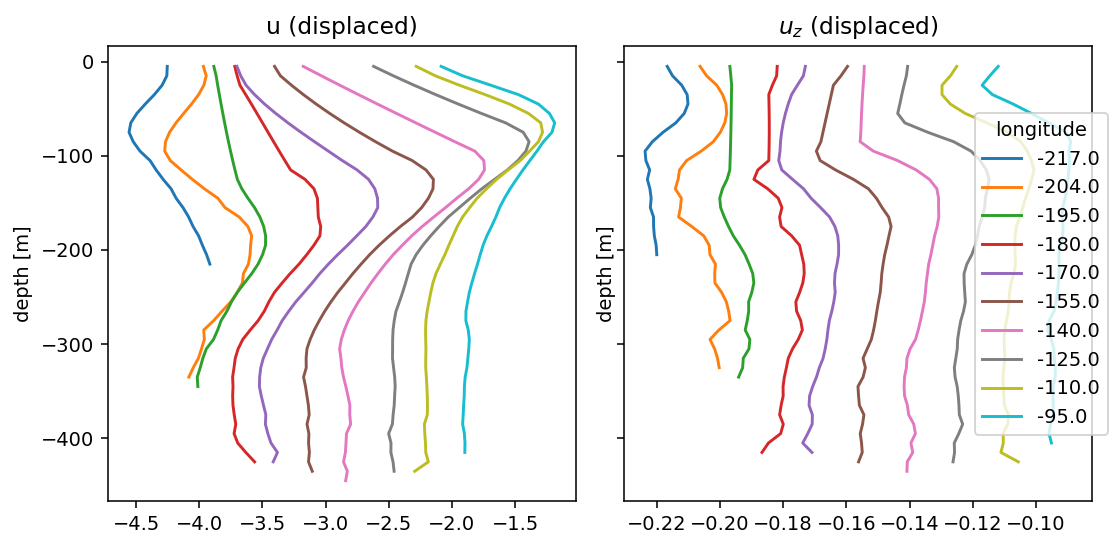

In [12]:
f, ax = plt.subplots(1, 2, sharey=True)

(johnson.u + (johnson.longitude/50)).plot.line(hue='longitude', y='depth', add_legend=False, ax=ax[0])
(johnson.u.differentiate('depth') + (johnson.longitude/1000)).plot.line(hue='longitude', y='depth', add_legend=False, ax=ax[1])
plt.gcf().legend(list(map(str, johnson.longitude.values)), title='longitude', loc='right')
plt.gcf().set_size_inches((8, 4))
plt.tight_layout()
ax[0].set_title('u (displaced)')
ax[1].set_title('$u_z$ (displaced)')

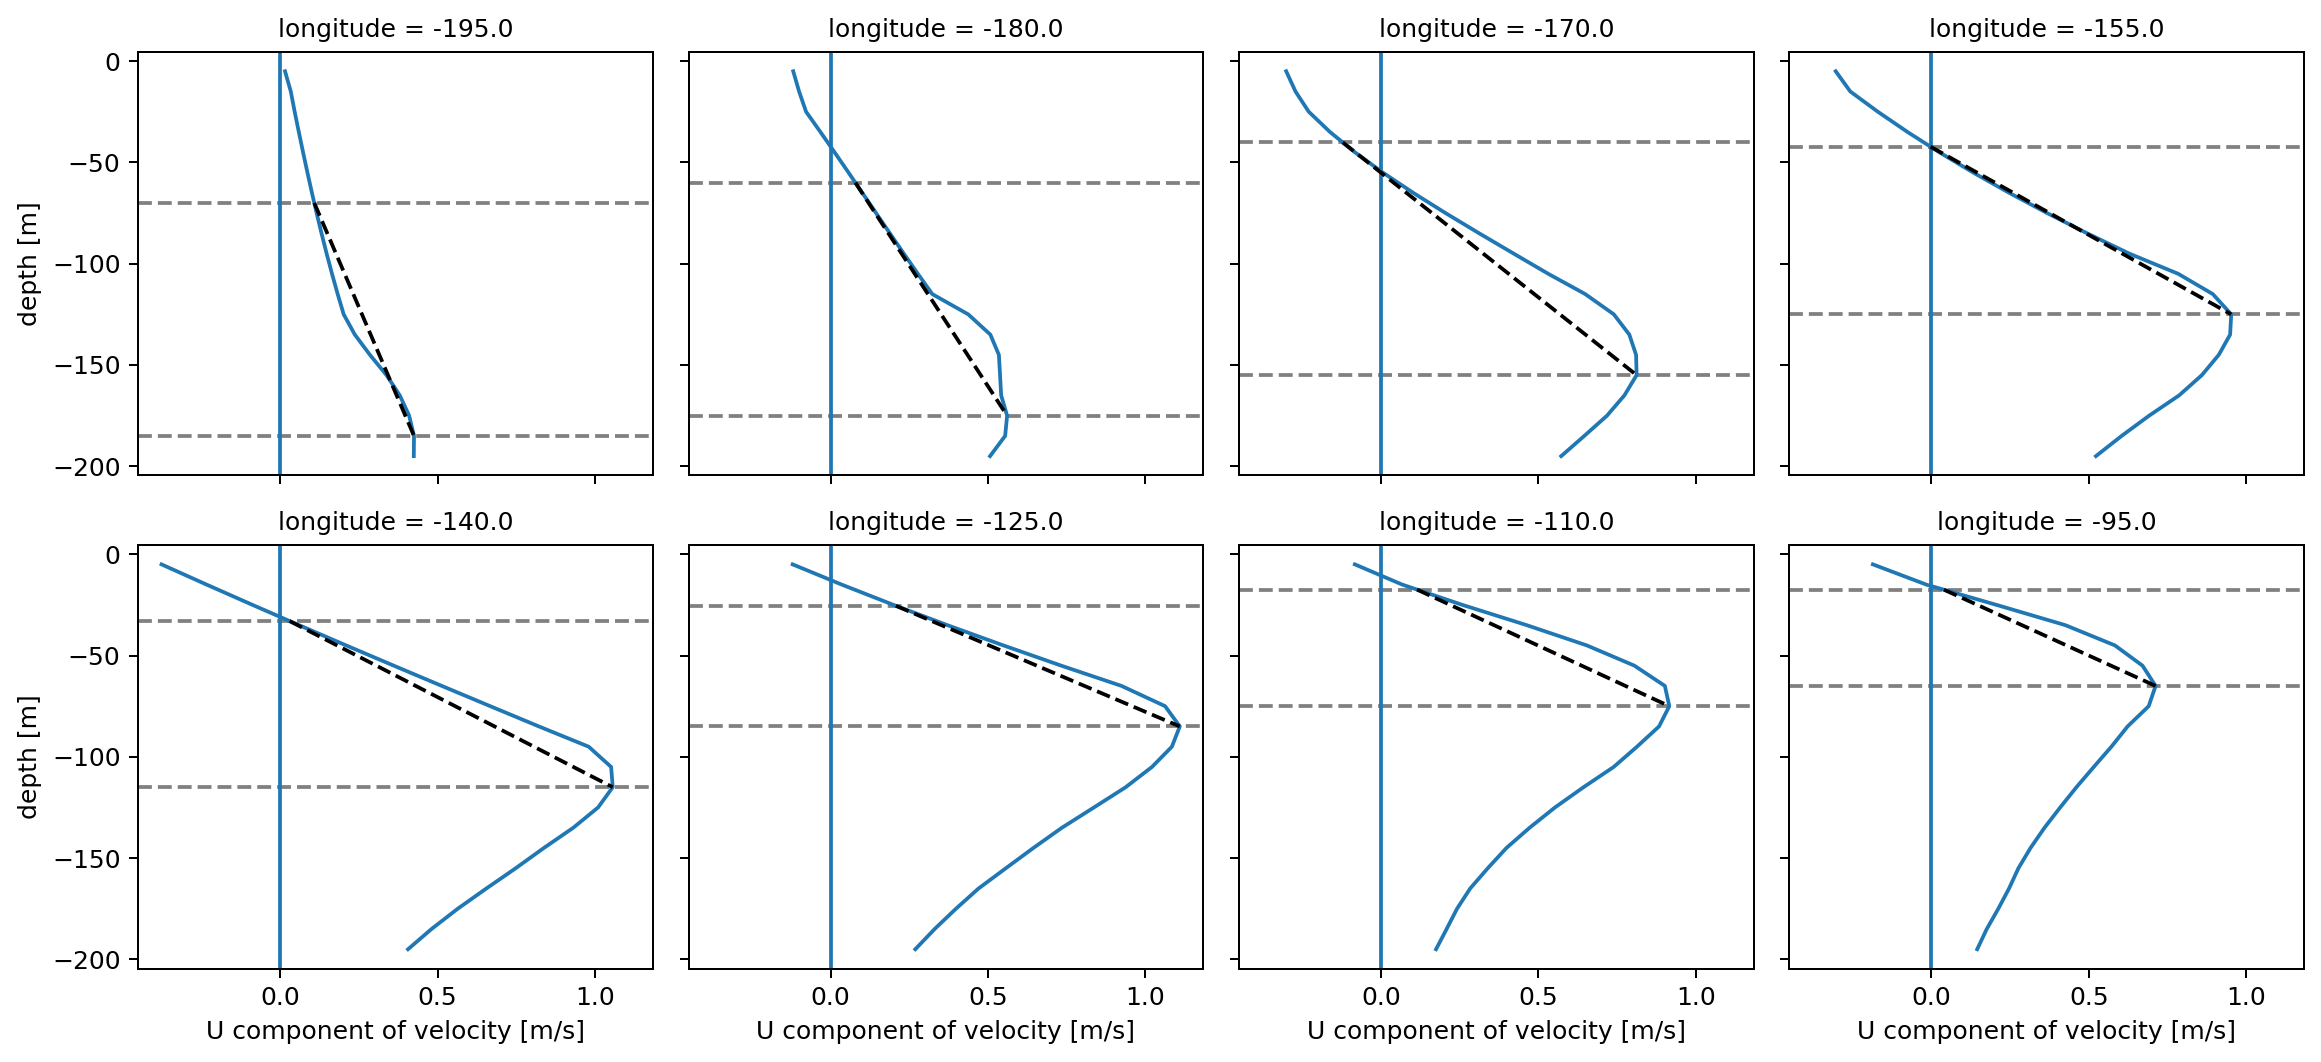

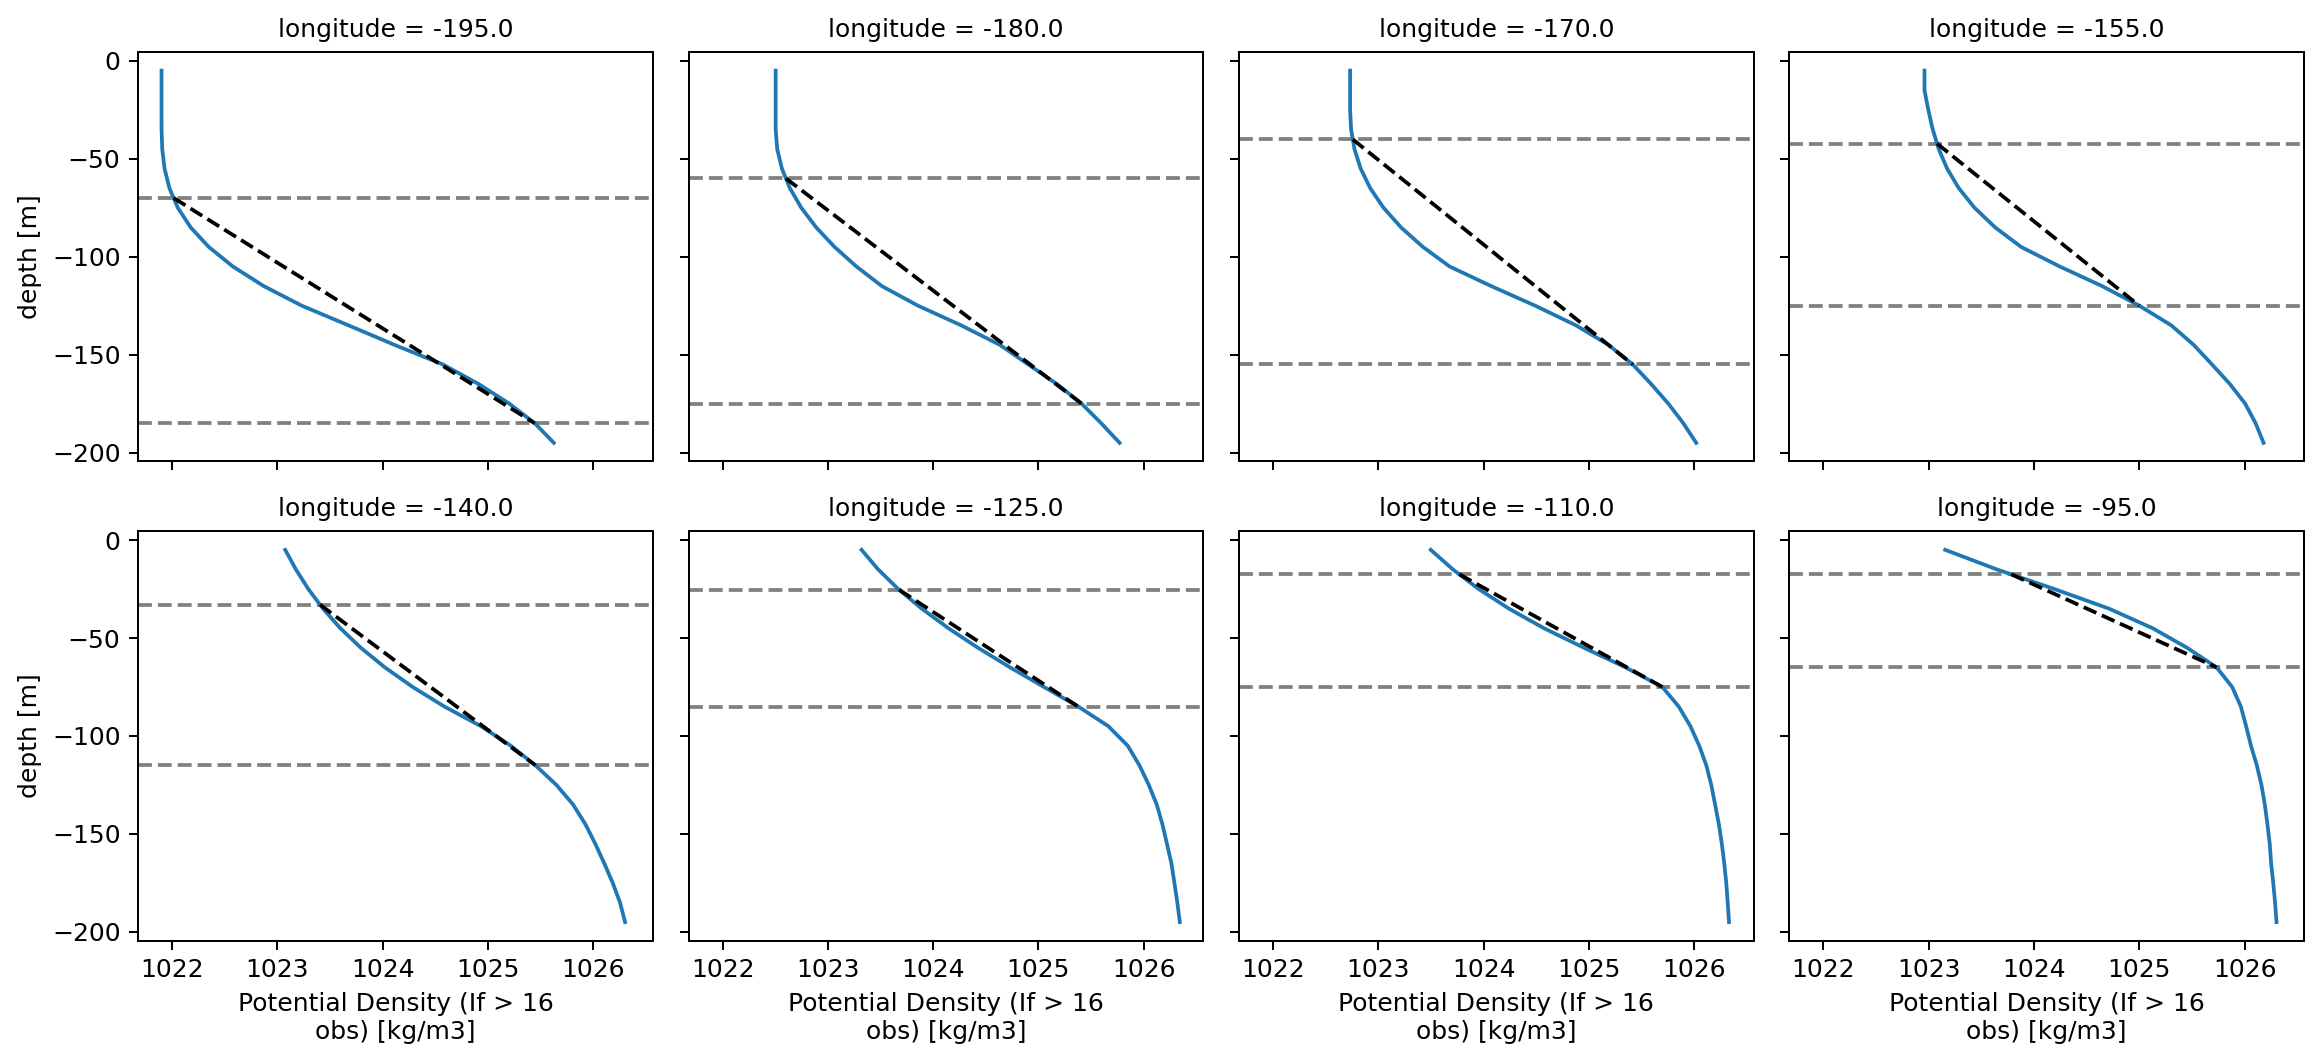

In [98]:
mld_interp = -1 * mimocmld.interp(longitude=johnson.longitude).load()
mld_interp.loc[{"longitude": -195}] = -70
mld_interp.loc[{"longitude": -180}] = -60


def plot_mld_eucmax(fg):
    for loc, ax in zip(fg.name_dicts.flat, fg.axes.flat):
        mld = mld_interp.sel(loc)
        eucmax = johnson.eucmax.sel(loc)
        if loc is None:
            continue
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            dcpy.plots.liney([mld, eucmax], ax=ax)
            ax.plot(
                fg.data.sel(loc).interp(depth=[mld, eucmax]).data,
                [mld.data, eucmax.data],
                color="k",
                ls="--",
            )


subset = johnson.sel(longitude=slice(-200, -95), depth=slice(-200))
fg = subset.u.plot.line(col="longitude", y="depth", col_wrap=4)
fg.map(lambda: plt.axvline(0))
plot_mld_eucmax(fg)


fg = subset.dens.plot.line(col="longitude", y="depth", col_wrap=4)
plot_mld_eucmax(fg)

## median Ri_g profiles in depth & euc space

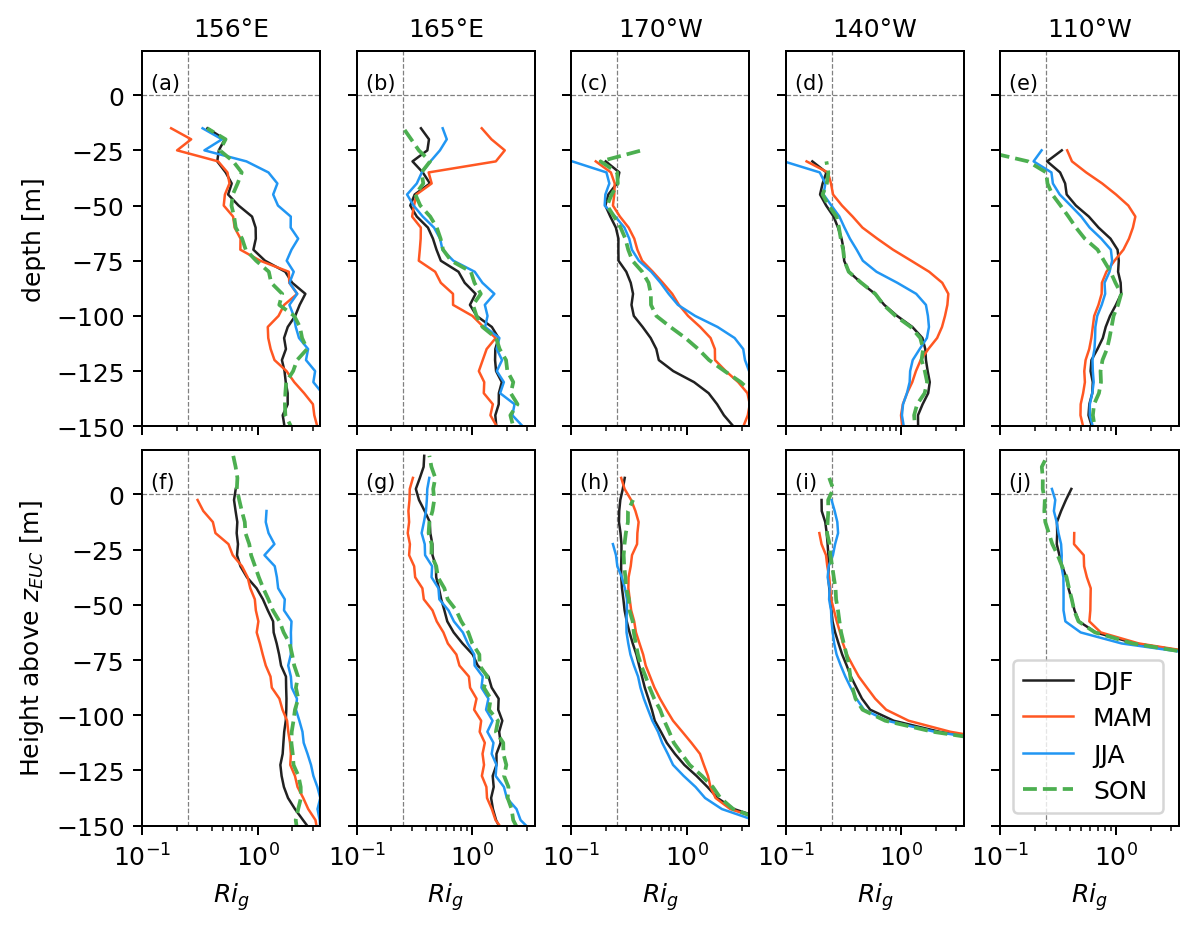

In [157]:
# Smyth & Moum (2013) colors
from cycler import cycler

sm13_colors = {
    "axes.prop_cycle": cycler(
        color=["#212121", "#FF5722", "#2196F3", "#4CAF50"],
        linestyle=["-", "-", "-", "--"],
        linewidth=[1] * 3 + [1.5],
    )
}


with mpl.rc_context(sm13_colors):
    fg = facetgrid.facetgrid(
        ["depth", "euc"],
        median_Rig_z.longitude,
        func=xr.plot.line,
        plot_kwargs=dict(
            ylim=[-150, 20],
            xlim=[0.1, 3.5],
            xscale="log",
            _labels=False,
            hue="season",
            add_legend=False,
        ),
    )

fg.map_row("depth", median_Rig_z, y="depth")
fg.map_row("euc", median_Rig.where(median_Rig.num_obs > 30 * 24), y="z_above_euc")

fg.set_xlabels("$Ri_g$")
fg.set_ylabels(["depth [m]", "Height above $z_{EUC}$ [m]"])
fg.set_col_labels(["156°E", "165°E", "170°W", "140°W", "110°W"])
fg.axes[-1, -1].legend(fg.handles["euc"][-1], median_Rig.season.values)

[dcpy.plots.linex(0.25, lw=0.5, ax=ax) for ax in fg.axes.flat]
[dcpy.plots.liney(0, lw=0.5, ax=ax) for ax in fg.axes.flat]

fg.fig.set_size_inches((dcpy.plots.pub_fig_width("jpo", "two column"), 5))
dcpy.plots.label_subplots(fg.axes.flat, fontsize="small")
fg.fig.savefig("../images/rig-profiles-depth-zeuc.png")

## fractional contributions

In [146]:
tao_zeuc = tao_zeuc.where(tao_zeuc.count("time") > 30 * 24)
Ri_q_annual = (
    tao_zeuc.Rig.sel(zeuc=slice(0, None))
    .chunk({"time": -1, "zeuc": -1})
    .quantile(q=[0.25, 0.5, 0.75], dim=["time", "zeuc"])
)
Ri_q_annual.load()

<xarray.DataArray 'Rig' (quantile: 3, longitude: 5)>
array([[0.81522617, 0.58695033, 0.26694281, 0.22278418, 0.26821389],
       [1.97553892, 1.58871084, 0.70549343, 0.41711624, 0.54069482],
       [5.45856488, 4.62699244, 2.61483129, 1.18364173, 1.5925003 ]])
Coordinates:
  * longitude  (longitude) float64 -204.0 -195.0 -170.0 -140.0 -110.0
  * quantile   (quantile) float64 0.25 0.5 0.75

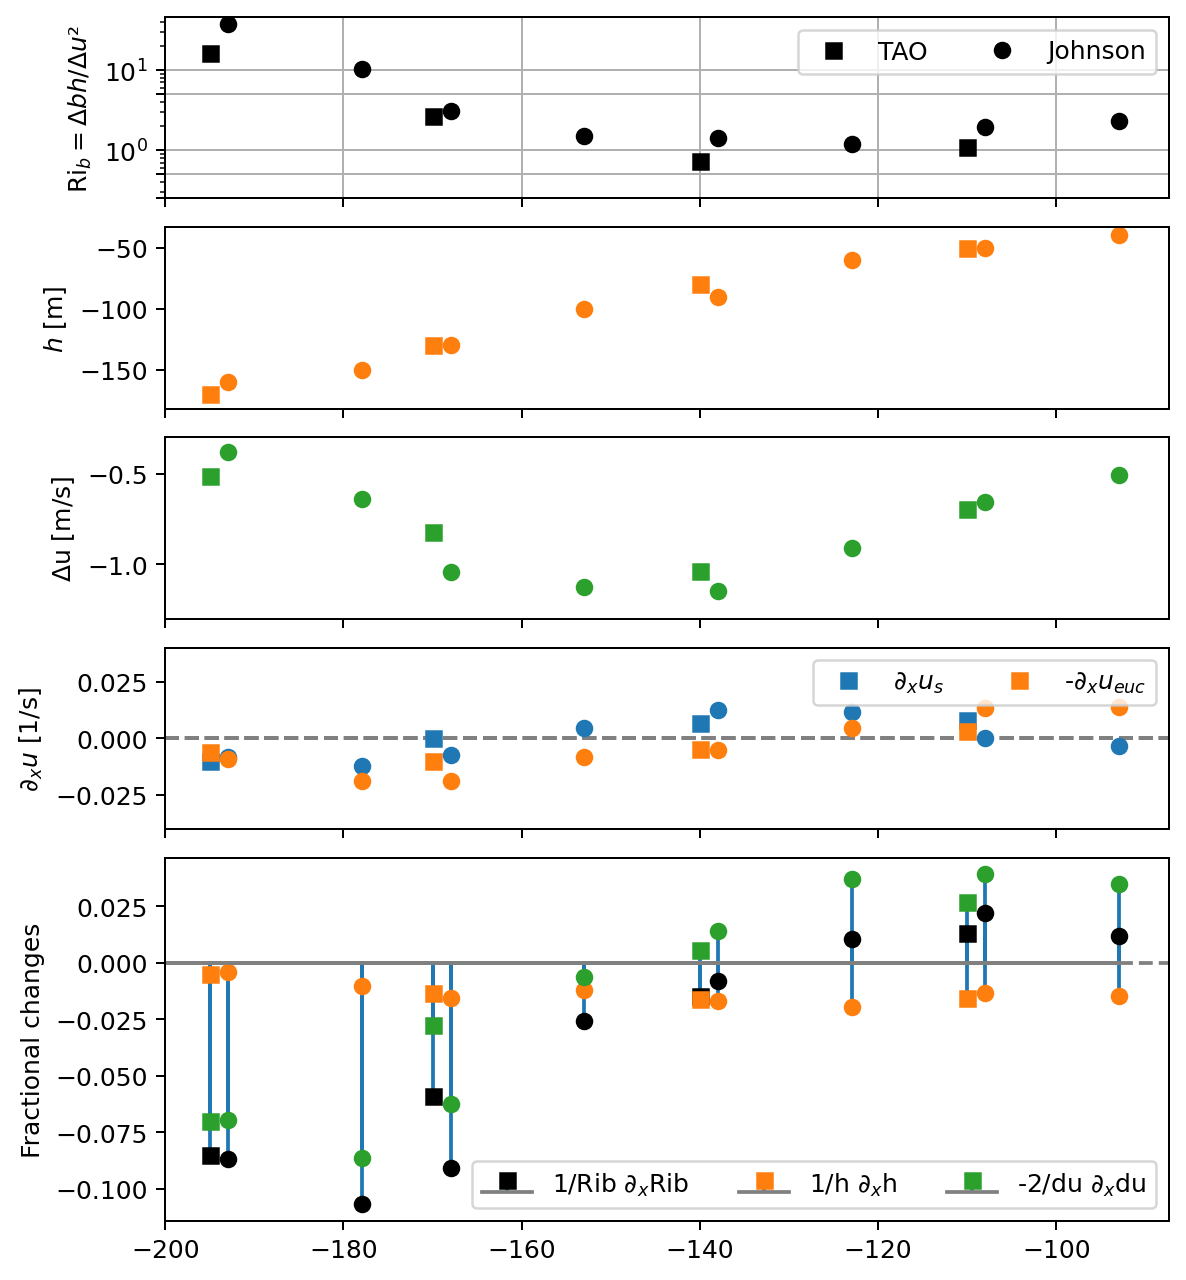

In [44]:
kwargs = {"buoy": False}

f, ax = pump.plot.plot_bulk_Ri_diagnosis(tao_clim, ls="none", marker="s", **kwargs)
# pump.plot.plot_bulk_Ri_diagnosis(tao_daily, ls="none", marker= 'o', f=f, ax=ax)

johnson_proc = johnson.sel(longitude=slice(-200, None))
johnson_proc["longitude"] = johnson_proc.longitude + 2.05

pump.plot.plot_bulk_Ri_diagnosis(
    johnson_proc, ls="none", marker="o", f=f, ax=ax, **kwargs
)
# ri.sel(zeuc=slice(0,None)).mean("zeuc").plot(ax=ax["Rib"], color='k')

# dcpy.plots.fill_between(
#    Ri_q_annual.sel(quantile=[0.25, 0.75]),
#    axis="y",
#    y="quantile",
#    x="longitude",
#    alpha=0.1,
#    ax=ax["Rib"],
#    color="k",
# )
# Ri_q_annual.sel(quantile=0.5).plot(color="k", ax=ax["Rib"], _labels=False)

ax["contrib"].set_xlim((-200, None))
ax["Rib"].set_title("")

ax["Rib"].legend(["TAO", "Johnson"], ncol=2)
f.set_size_inches(dcpy.plots.pub_fig_width("jpo", "two column"), 7)
f.savefig("../images/bulk-ri-fractional-contrib.png")

---
---
---


## Old version

### Ri profiles

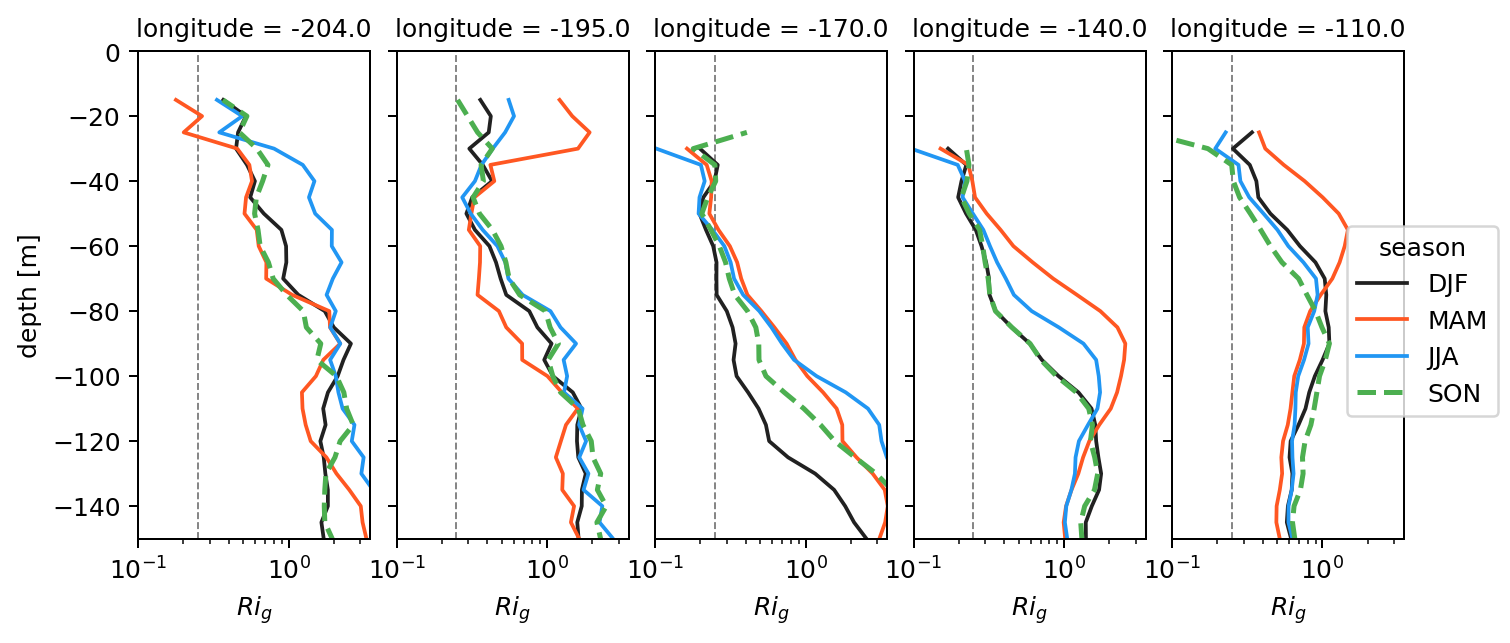

In [68]:
with mpl.rc_context(sm13_colors):
    fg = median_Rig_z.squeeze().plot.line(
        col="longitude",
        hue="season",
        y="depth",
        ylim=[-150, 0],
        xlim=[0.1, 3.5],
        xscale="log",
    )
fg.map(lambda: dcpy.plots.linex([0.25], lw=0.75))
plt.gcf().set_size_inches((8, 4))

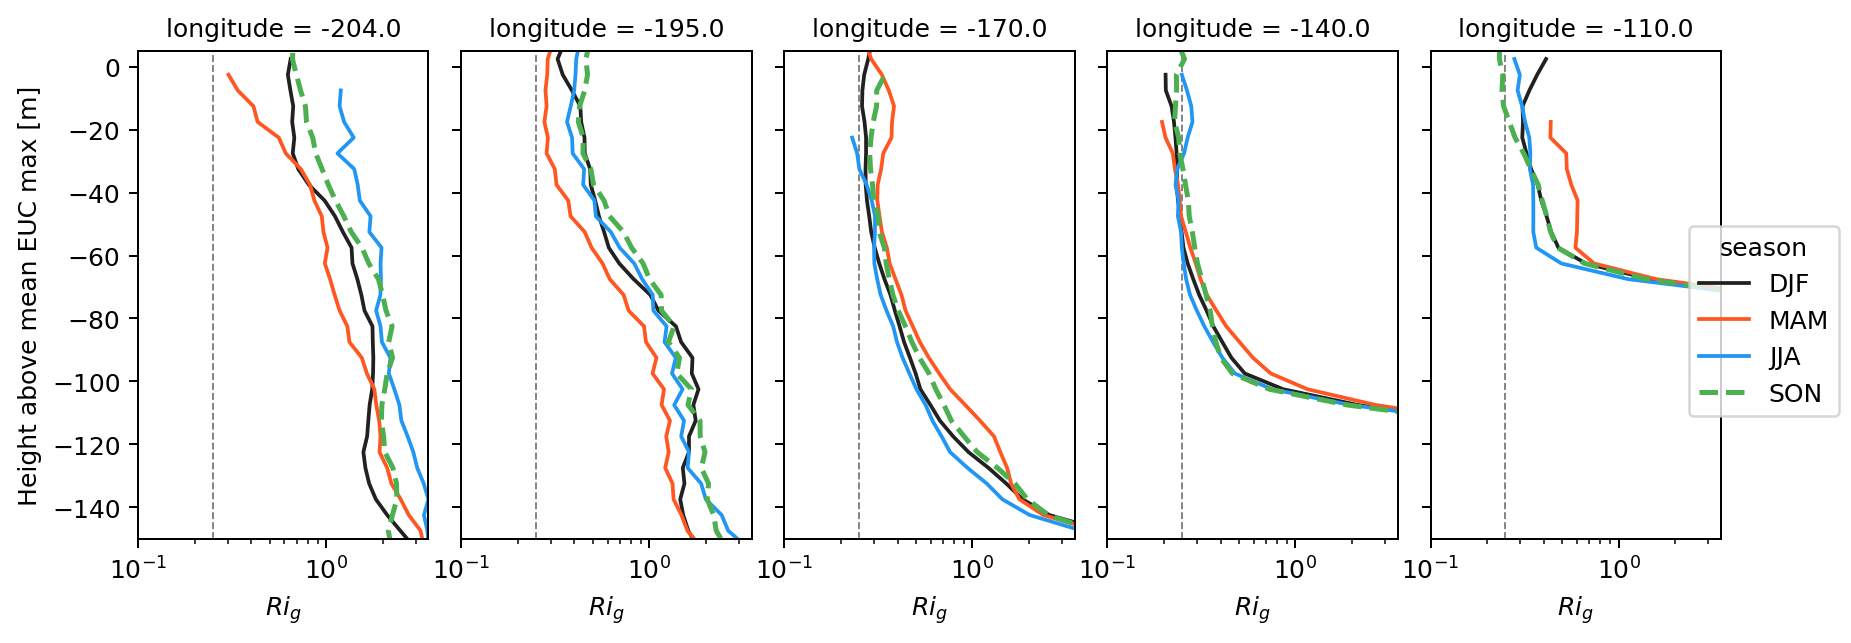

In [67]:
with mpl.rc_context(sm13_colors):

    fg = median_Rig.where(median_Rig.num_obs > 30 * 24).plot.line(
        col="longitude",
        hue="season",
        y="z_above_euc",
        xlim=[1e-1, 3.5],
        ylim=[-150, 5],
        xscale="log",
    )

fg.map(lambda: dcpy.plots.linex(0.25, lw=0.75))
fg.fig.set_size_inches((10, 4))

## Test MLD vs 25m for surface

Ideally we would only see errors in $h$, that seems to be the case

### TAO

Also not bad!

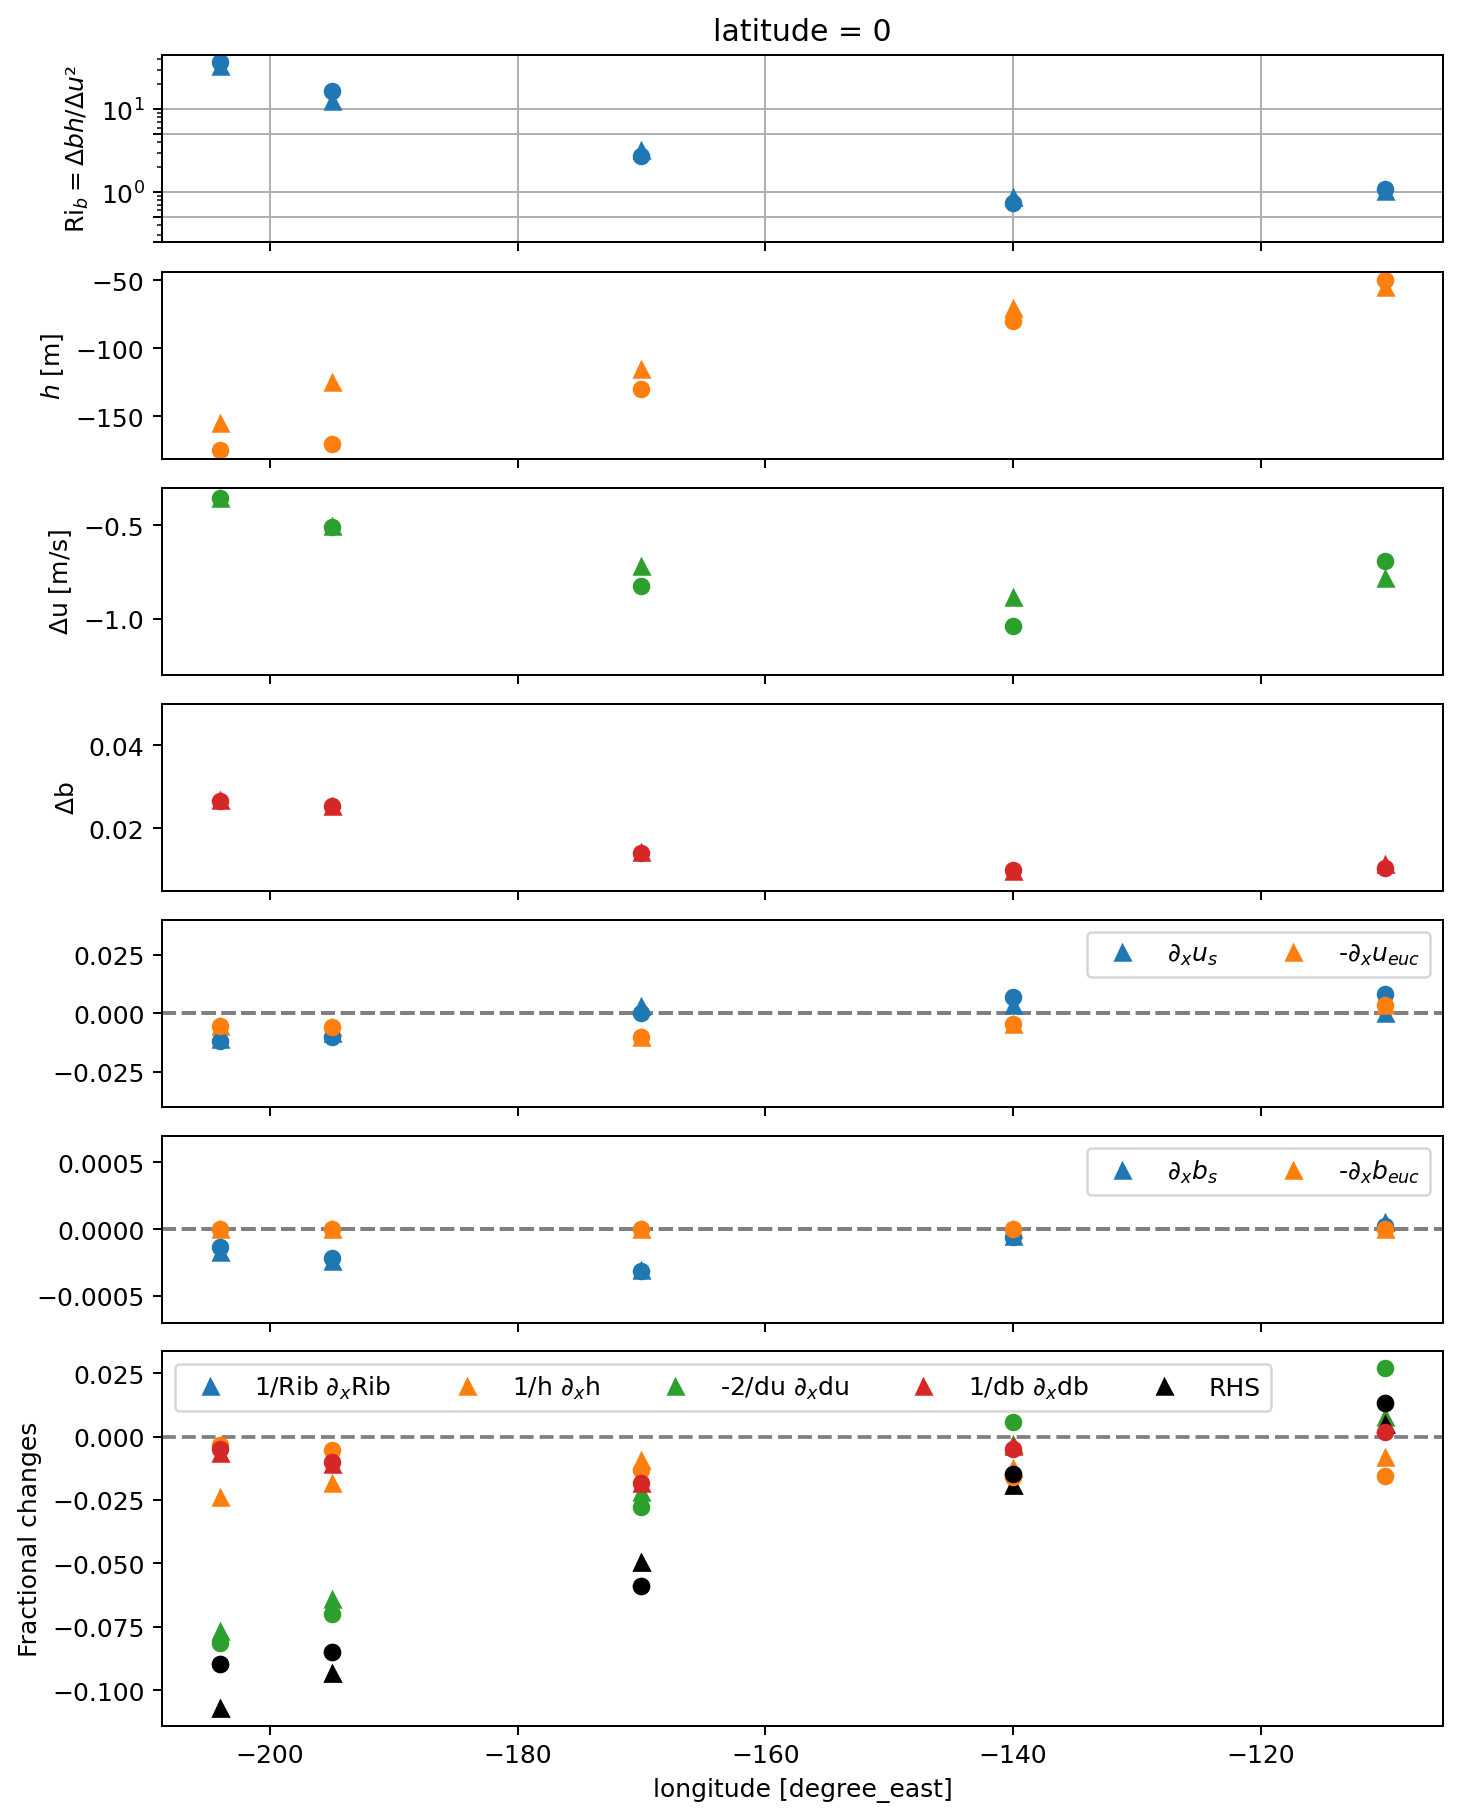

In [15]:
tao_clim = pump.calc.estimate_bulk_Ri_terms(tao_clim)
f, ax = pump.plot.plot_bulk_Ri_diagnosis(tao_clim, ls="none", marker="^")

tao_clim = pump.calc.estimate_bulk_Ri_terms(tao_clim, use_mld=False)
pump.plot.plot_bulk_Ri_diagnosis(tao_clim, ls="none", marker="o", f=f, ax=ax);

### Johnson

Not bad once I take out the western most two points where the linear approx is bad. Before that:
1. With MLD, it looked like Ri_b was (high, low, high) so dRi/dx was positive.
2. Fixed by throwing out the westernmost two points.

Triangles and circles agree pretty closely so this is not bad

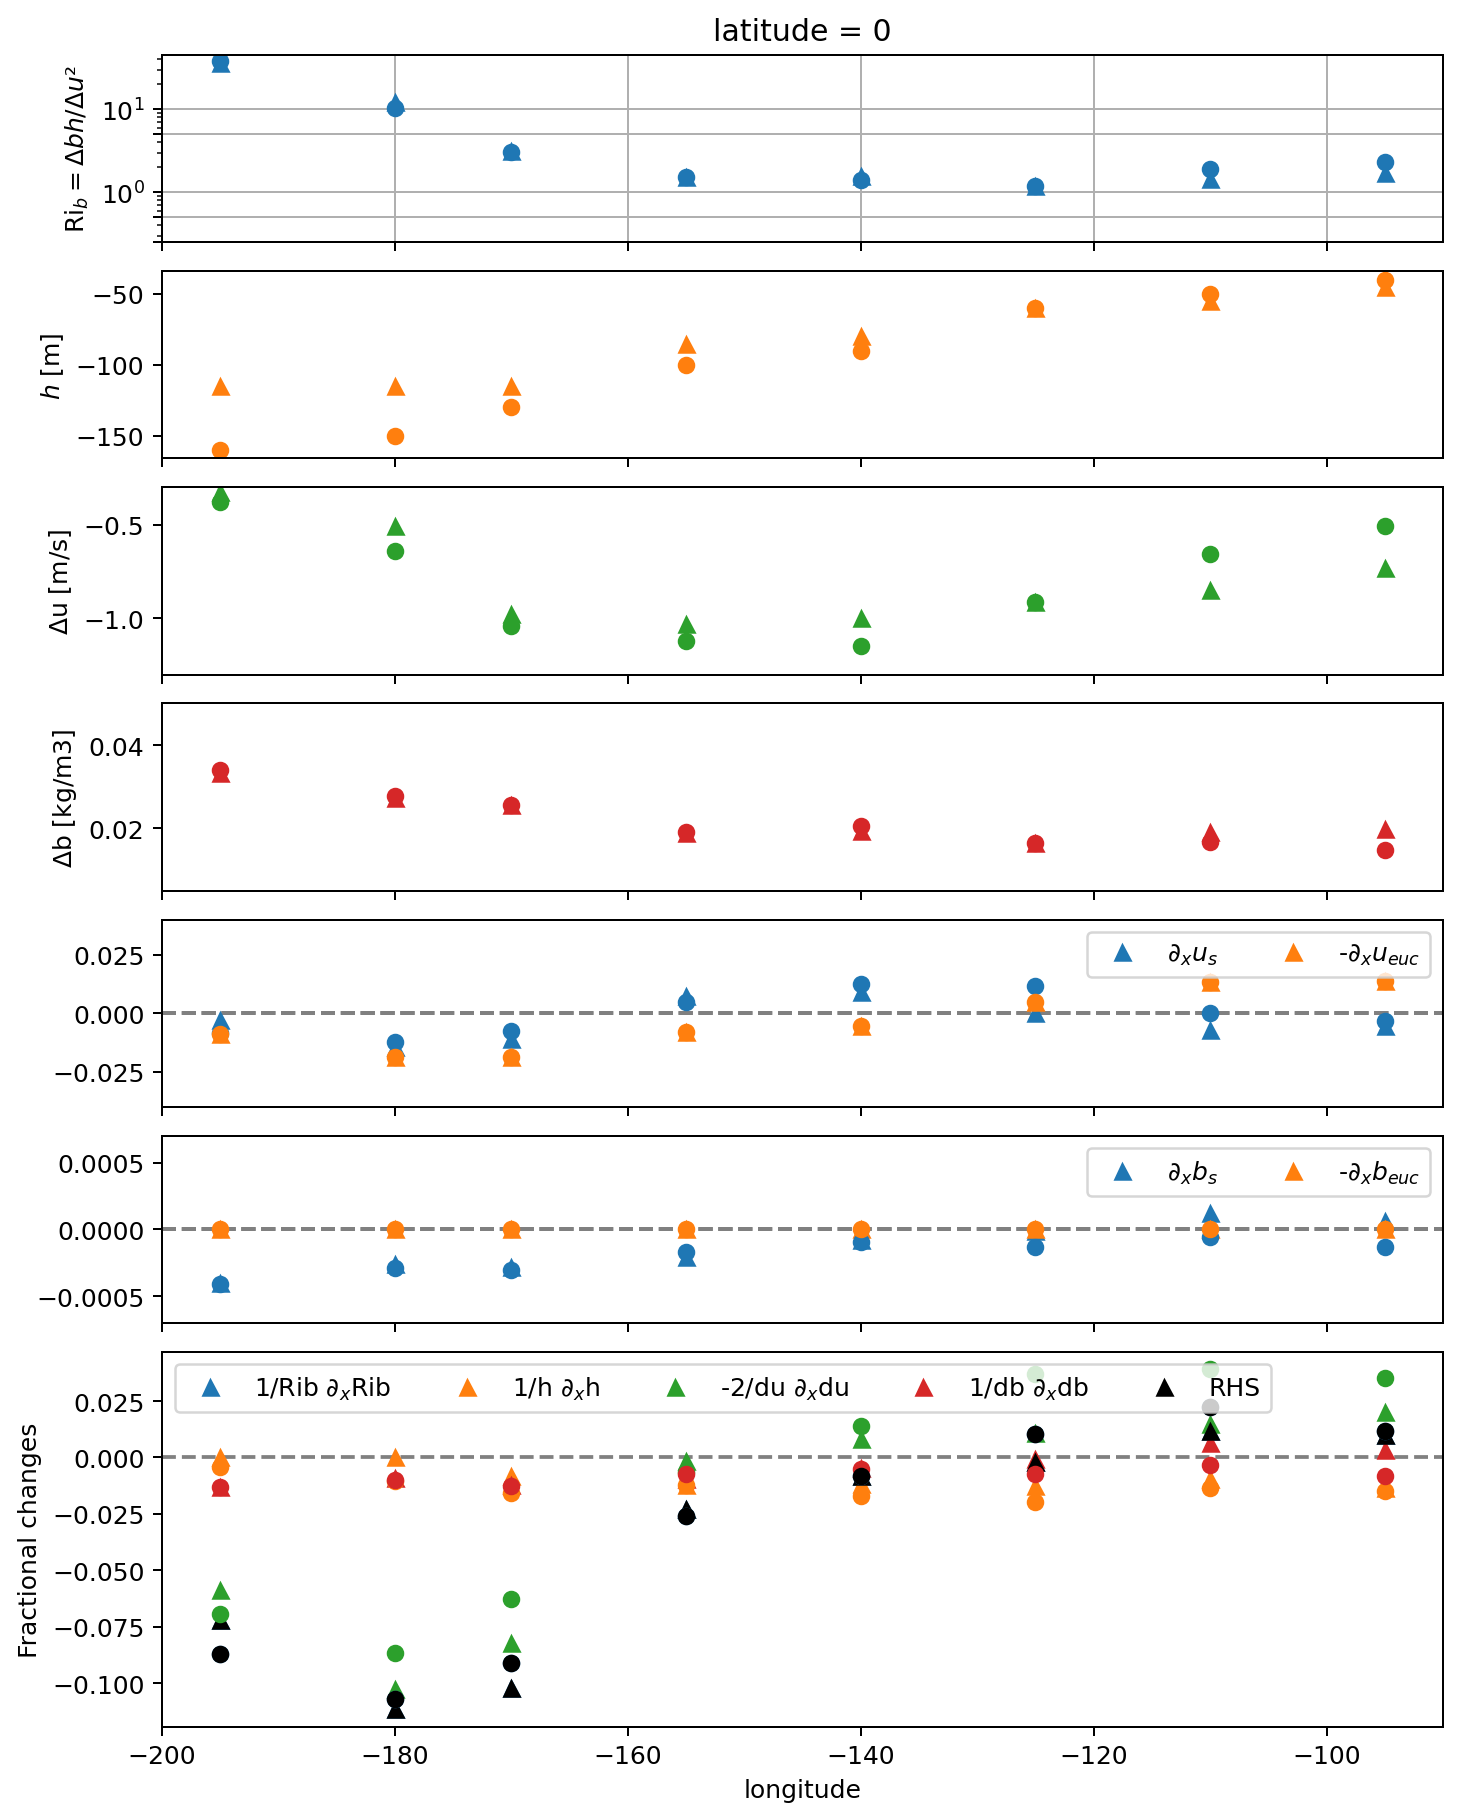

In [14]:
johnson = pump.calc.estimate_bulk_Ri_terms(johnson.isel(longitude=slice(2,None)))
f, ax = pump.plot.plot_bulk_Ri_diagnosis(johnson, ls="none", marker="^")

johnson = pump.calc.estimate_bulk_Ri_terms(johnson, use_mld=False)
pump.plot.plot_bulk_Ri_diagnosis(johnson, ls="none", marker="o", f=f, ax=ax);